In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [22]:
save_location = "/media/bhux/alpha/xsd_mvp/test/"

# uniform, lg, gaussian

NUMERICAL = 12
CATEGORICAL = 0

INFILLING_TYPE = ''
NOISE_TYPE = ''

In [23]:
from copy import deepcopy

def m(v):
    nonnull = v[np.isnan(v) == False]
    return np.mean(nonnull)

def std(v):
    nonnull = v[np.isnan(v) == False]
    return np.std(nonnull)

def infill_null(v):
    v[np.isnan(v)] = 0
    return v

def remove_outliers(lists):
    b = np.ones(lists[0].shape)

    for l in lists:
        q1 = np.nanquantile(l,0.25)
        q3 = np.nanquantile(l,0.75)

        iqr = q3 - q1
        lower = q1 - 1.5*iqr
        upper = q3 + 1.5*iqr

        b = np.logical_and(b, np.logical_or(l > lower , np.isnan(l)))
        b = np.logical_and(b, np.logical_or(l < upper , np.isnan(l)))
    
    return b

def norm(v):
    nonnull = v[np.isnan(v) == False]
    max = np.nanmax(nonnull)
    min = np.nanmin(nonnull)

    return 2*((v - min) / (max - min))-1

def get_local_gaussian(ys, numbins=50):
    max = np.nanmax(ys)
    min = np.nanmin(ys)
    bins = np.linspace(min, max, num=numbins)
    s_ys = np.array(sorted(ys, reverse=True))

    d, m, s = [], [], []
    for i in range(numbins-1):
        low = bins[i]
        high = bins[i+1]
        tbool = np.logical_and(low<=s_ys, s_ys<=high)
        data = s_ys[tbool]
        d.append(len(data))
        m.append(data.mean() if not np.isnan(data.mean()) else low)
        s.append(data.std() if not np.isnan(data.std()) else 0.01)
    d = np.array(d) / sum(d)

    return d, np.array(m), np.array(s)

def convert_categorical(ys, numbins=50):
    max = np.nanmax(ys)
    min = np.nanmin(ys)
    bins = np.linspace(min, max, num=numbins)
    s = np.array(sorted(enumerate(ys), key=lambda x:x[1]))
    s_inds = s[:,0].astype(int)
    s_ys = s[:,1]

    nys = deepcopy(ys)
    for i in range(numbins-1):
        low = bins[i]
        high = bins[i+1]
        tbool = np.logical_and(low<=s_ys, s_ys<=high)
        
        if sum(tbool) > 1:
            nys[np.array(s_inds[tbool])] = i+1

    print(i+1)
    nys[np.isnan(nys)] = 0
    return nys

def sample_local_gaussian(v, numbins=50):
    d,m,s = get_local_gaussian(v, numbins=numbins)
    num = sum(np.isnan(v))

    samples = np.random.choice(numbins-1, num, p=d)
    rand_n = np.random.randn(num)

    adjust = m[samples] + 1.2 * rand_n *s[samples]
    
    # override 
    #adjust = np.zeros(adjust.shape)
    
    if INFILLING_TYPE == "zeros":
        adjust = np.zeros(adjust.shape)

    if INFILLING_TYPE == "uniform":
        adjust = np.random.uniform(low=-1.0, high=1.0, size=adjust.shape)

    if INFILLING_TYPE == "gaussian":
        adjust = np.random.normal(size=adjust.shape)

    v[np.isnan(v)] = adjust
    return v, (d,m,s)


def sample_noise(b, dmss, numbins=50):
    if NOISE_TYPE == "uniform":
        return np.random.uniform(low=-1.0, high=1.0, size=(b,NUMERICAL))
    
    if NOISE_TYPE == "gaussian":
        return np.random.normal(size=(b,NUMERICAL))

    vs = []
    for d,m,s in dmss:
        samples = np.random.choice(numbins-1, b, p=d)
        rand_n = np.random.randn(b)
        vs.append(m[samples] + 1.2 * rand_n *s[samples])
    return np.stack(vs, axis=-1)

def unison_shuffled_copies(a, b):
    #assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return np.array(a)[p], np.array(b)[p]

In [24]:
def xyhist(x, y, title):
    plt.hist(x, bins=50, alpha=0.5, label='Synthetic', density=True)
    plt.hist(y, bins=50, alpha=0.5, label='Real', density=True)
    plt.title(title)
    plt.yscale('log')
    plt.xlabel("Normalized Range")
    plt.ylabel("Probability Density")
    plt.legend(loc='upper right')
    plt.show()

In [25]:
PATH = "./data/xtended_data_all.csv"
gt = pd.read_csv(PATH).drop(labels=['Drug'], axis=1)
f = pd.read_csv(PATH)
smiles = f['Drug'].values
vlists = {
    col: f[col].values for col in f.drop(labels=['Drug'], axis=1).columns[:12] 
}



inmask = remove_outliers([v for _,v in vlists.items()])
print(sum(inmask))
smiles = smiles[inmask]
vlists = {
    k: v[inmask] for k,v in vlists.items()
}

vlists = {
    k: norm(v) for k,v in vlists.items()
}


# for col in f.drop(labels=['Drug'], axis=1).columns[:NUMERICAL]:
#     vlists[col+"_cat"] = vlists[col]

nullmask = np.stack([
    np.isnan(v)==False for _,v in vlists.items()
    ], axis=-1)

dmss = []
for k,v in vlists.items():
    vlists[k], dms = sample_local_gaussian(v, numbins=10)
    dmss.append(dms)

for col in f.drop(labels=['Drug'], axis=1).columns[:12]:
    vlists[col+"_cat"] = convert_categorical(vlists[col], numbins=10)

print(vlists)

filename = "/media/bhux/alpha/xsd_mvp/3000e_ac_0.0005/1000_dict.csv"
vals = pd.read_csv(filename).values

smiles_vs = []
preds = {i:[] for i in range(len(vlists.items()))}
for v in vals:
    v[1] = [float(s) for s in v[1].split("[")[1].split("]")[0].split(" ") if s != '']
    smiles_vs.append(v[0])
    for i, val in enumerate(v[1]):
        preds[i].append(val)

28444
9
9
9
9
9
9
9
9
9
9
9
9
{'Caco2_Wang': array([-0.22431264,  0.22436959,  0.10754829, ..., -0.42478681,
        0.4524161 ,  0.05616524]), 'Lipophilicity_AstraZeneca': array([ 0.19526042,  0.74734182, -0.08093528, ...,  0.5       ,
        0.31286576,  0.47884263]), 'Solubility_AqSolDB': array([0.00672264, 0.04008241, 0.04051288, ..., 0.09523034, 0.02881997,
       0.45761106]), 'HydrationFreeEnergy_FreeSolv': array([ 0.50209395,  0.16323728,  0.15437638, ...,  0.38640156,
       -0.86594538, -0.03355317]), 'PPBR_AZ': array([ 0.70074024,  1.09420658,  0.92070185, ...,  0.92842435,
        0.00587043, -0.22926299]), 'VDss_Lombardo': array([-0.99048069,  0.74807137, -0.86810185, ..., -0.97481047,
       -0.63603134, -0.73003954]), 'Half_Life_Obach': array([-0.63446229, -0.86567703, -1.02015241, ..., -0.29165413,
       -0.99421535, -0.06444074]), 'Clearance_Hepatocyte_AZ': array([ 0.13067382, -0.68444915, -0.91986838, ..., -1.07128119,
       -1.03483068, -0.35705168]), 'Clearance_M

Index(['Caco2_Wang', 'Lipophilicity_AstraZeneca', 'Solubility_AqSolDB',
       'HydrationFreeEnergy_FreeSolv', 'PPBR_AZ', 'VDss_Lombardo',
       'Half_Life_Obach', 'Clearance_Hepatocyte_AZ', 'Clearance_Microsome_AZ',
       'LD50_Zhu', 'herg_central_hERG_at_1uM', 'herg_central_hERG_at_10uM'],
      dtype='object')
0 0
0
preds -1.0 0.0
act 0.11610625602544569 0.38893078711094714
here
0 1
1
preds -1.0 0.0
act 0.182075935415298 0.42026045126386635
here
0 2
2
preds -1.0 0.0
act 0.10792054960293129 0.413687241892273
here
0 3
3
preds -1.0 0.0
act 0.0997179945700639 0.42699608036139663
here
1 0
4
preds -1.0 0.0
act 0.5779022295260635 0.4927748114499608
here
1 1
5
preds -1.0 0.0
act -0.6043492793400495 0.4429578734248081
here
1 2
6
preds -1.0 0.0
act -0.5580801314993826 0.45105038634270156
here
1 3
7
preds -1.0 0.0
act -0.5449918803046688 0.6084131286698706
here
2 0
8
preds -1.0 0.0
act -0.6698919345399695 0.4433599177642987
here
2 1
9
preds -1.0 0.0
act -0.03726224508332338 0.372413305969940

Text(0.5, 0.98, 'Real vs Synthetic Data (Density)')

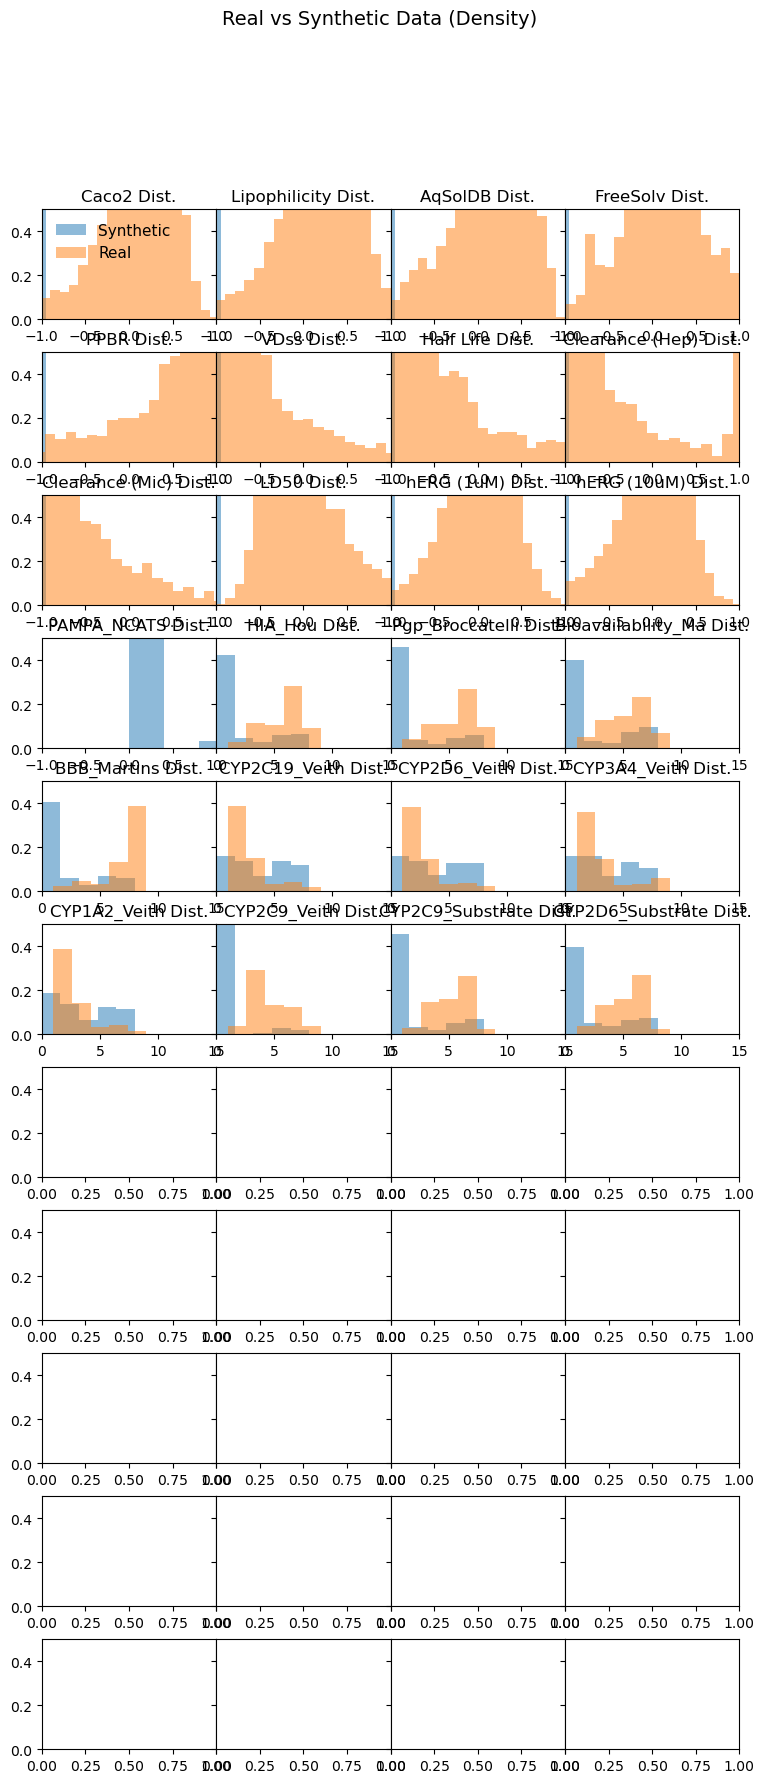

In [27]:
fig = plt.figure(figsize=(9,20))
gs = fig.add_gridspec(11,4, wspace=0, hspace=0.3)
ax = gs.subplots(sharey=True, sharex=False)

print(gt.columns)
names = [
    "Caco2",
    "Lipophilicity",
    "AqSolDB",
    "FreeSolv",
    "PPBR",
    "VDss",
    "Half Life",
    "Clearance (Hep)",
    "Clearance (Mic)",
    "LD50",
    "hERG (1uM)",
    "hERG (10uM)",
    # Categorical
    'PAMPA_NCATS',
    'HIA_Hou',
    'Pgp_Broccatelli',
    'Bioavailability_Ma',
    'BBB_Martins',
    'CYP2C19_Veith',
    'CYP2D6_Veith',
    'CYP3A4_Veith',
    'CYP1A2_Veith',
    'CYP2C9_Veith',
    'CYP2C9_Substrate',
    'CYP2D6_Substrate',
    # 'CYP3A4_Substrate',
    # 'AMES',
    # 'DILI',
    # 'Skin Reaction',
    # 'Carcinogens_Lagunin',
    # 'ClinTox',
    # 'Tox21NR-AR', 'Tox21NR-AR-LBD', 'Tox21NR-AhR', 'Tox21NR-Aromatase',
    #    'Tox21NR-ER', 'Tox21NR-ER-LBD', 'Tox21NR-PPAR-gamma', 'Tox21SR-ARE',
    #    'Tox21SR-ATAD5', 'Tox21SR-HSE', 'Tox21SR-MMP', 'Tox21SR-p53'
]

for c, (col, y) in enumerate(vlists.items()):
    #print(c//6, c%6)
    i = c // 4
    j = c % 4

    print(i,j)

    x = preds[c]

    print(c)
    print("preds", np.average(x), np.std(x))
    print("act", np.average(y), np.std(y))
    
    bins=20
    if c > 12:
        bins=5
    if c< 12:
        print("here")

    ax[i][j].set_title(f"{names[c]} Dist.", fontsize=12)
    ax[i][j].hist(x, bins=bins, alpha=0.5, label='Synthetic', density=True)
    ax[i][j].hist(y, bins=bins, alpha=0.5, label='Real', density=True)
    ax[i][j].set_ylim(0,1)
    ax[i][j].set_xlim(-1,1)
    if c > 12:
        ax[i][j].set_ylim(0,0.5)
        ax[i][j].set_xlim(0,10)
    ax[i][j].get_xaxis().set_ticks([])
    ax[i][j].get_yaxis().set_ticks([])
    #plt.yscale('log')

    # xyhist(preds[i], vlists[col], f"{col} Real vs Synthetic Data (Epoch: {e})")

ax[0][0].legend(loc='upper left', fontsize=11, frameon=False)
fig.suptitle("Real vs Synthetic Data (Density)", fontsize=14)